In [1]:
%load_ext autoreload
%autoreload 2
import torch
from pathlib import Path
from tqdm import tqdm
import eq

In [2]:
import pytorch_lightning as pl

## Loading the catalog
We load the catalog like in the previous notebook.

In [4]:
# !rm -rf /home/gcl/RB/kdascher/Projects/MAG_RECAST/recast/data/ANSS_MultiCatalog
catalog = eq.catalogs.ANSS_MultiCatalog(    
    num_sequences=10000,
    t_end_days=4*365,
    mag_completeness=4.5,
    minimum_mainshock_mag=6.0,
)

Loading existing catalog from /home/gcl/RB/kdascher/Projects/DS_Discovery/recast/data/ANSS_MultiCatalog.


/home/gcl/RB/kdascher/Projects/DS_Discovery/recast/eq/data/sequence.py:207: UserWarning: Found 1 zero inter-event times in the sequence. This violates fundamental assumptions of TPP models and may lead to incorrect log-likelihood values.
  warnings.warn(


## Loading a trained model
All models trained on the default versions of the catalog are stored in `{PROJECT_ROOT_DIR}/trained_models/`.

In [5]:
trained_models_dir = Path(eq.__file__).parents[1] / "trained_models"
trained_models_dir

PosixPath('/home/gcl/RB/kdascher/Projects/DS_Discovery/recast/trained_models')

In [6]:
# model = eq.models.RecurrentTPP.load_from_checkpoint(trained_models_dir / "White_RecurrentTPP.ckpt")
filename ="/home/gcl/RB/kdascher/Projects/MAG_RECAST/recast/notebooks/exploratory_notebooks/multicatalog_forecasts/lightning_logs/version_25/checkpoints/epoch=17-step=216.ckpt"
model = eq.models.RecurrentTPP.load_from_checkpoint(filename)
model.eval()

RecurrentTPP(
  (hypernet_time): Linear(in_features=32, out_features=96, bias=True)
  (hypernet_mag): Linear(in_features=32, out_features=1, bias=True)
  (rnn): GRU(2, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

## Prepare the data

We trained the TPP model using the `train` and `val` sequences. Now we will use the unseen section of the `test` sequence (in orange) to evaluate forecasting performance of the model. 

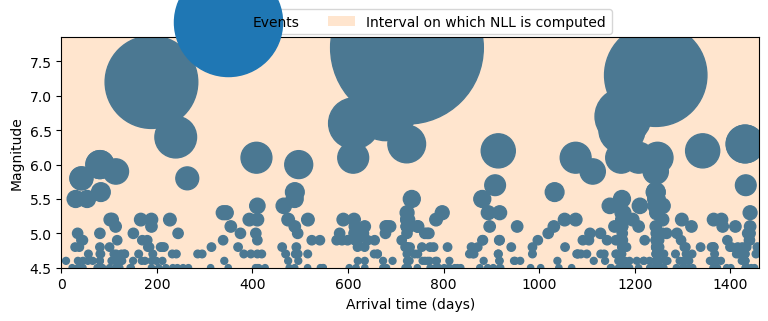

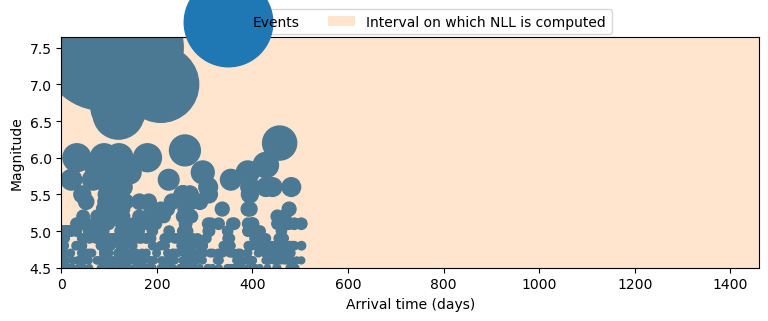

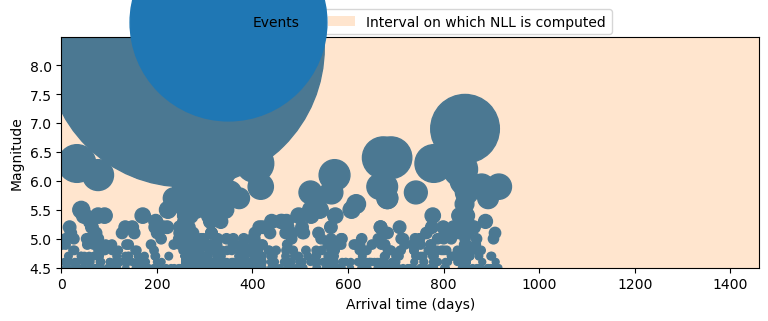

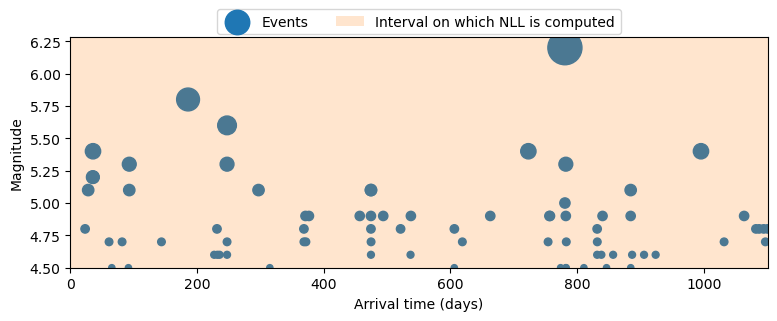

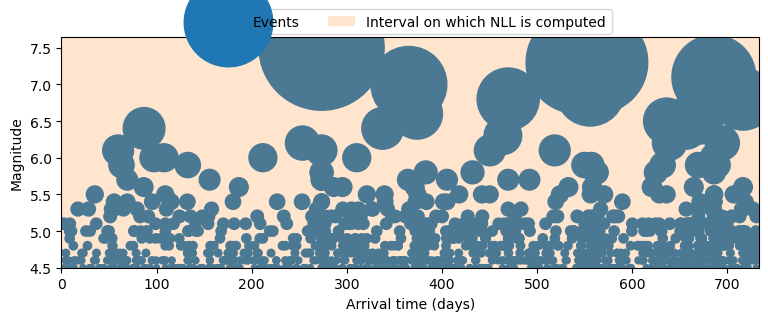

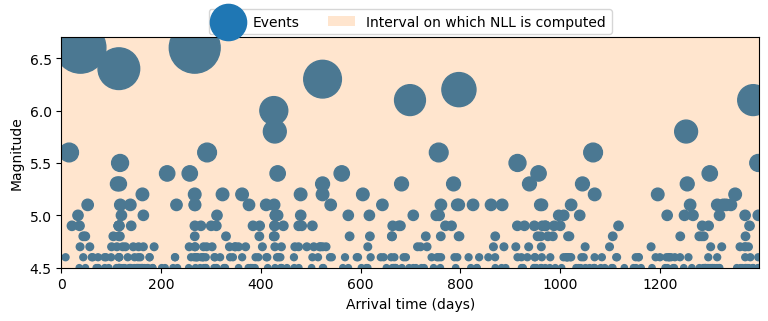

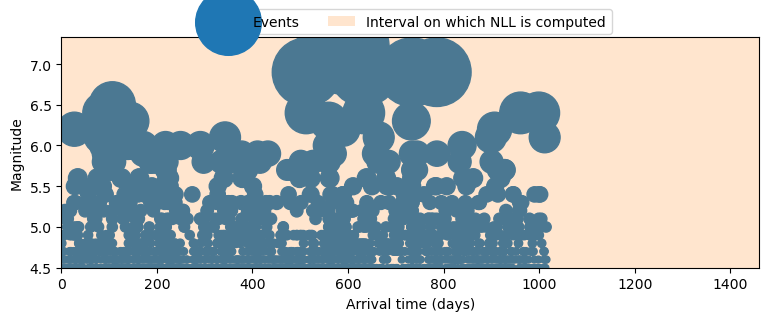

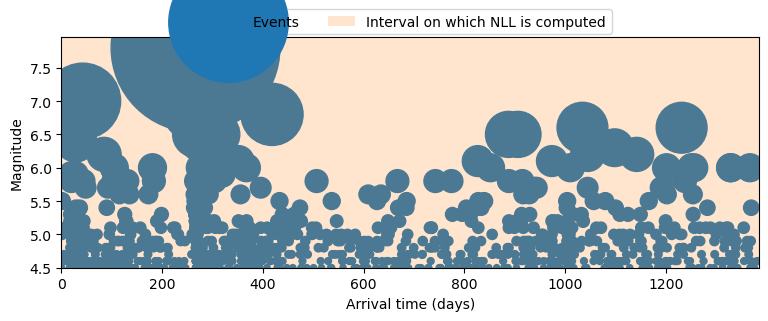

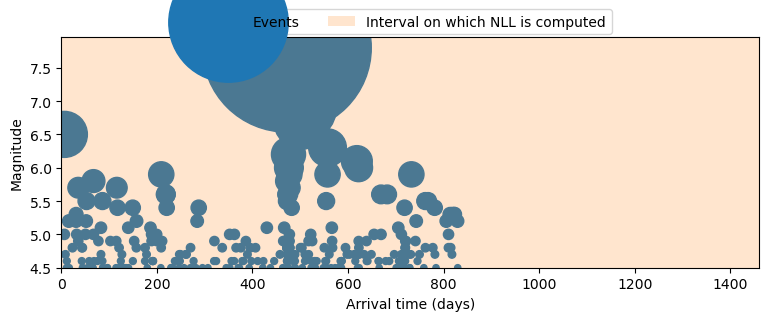

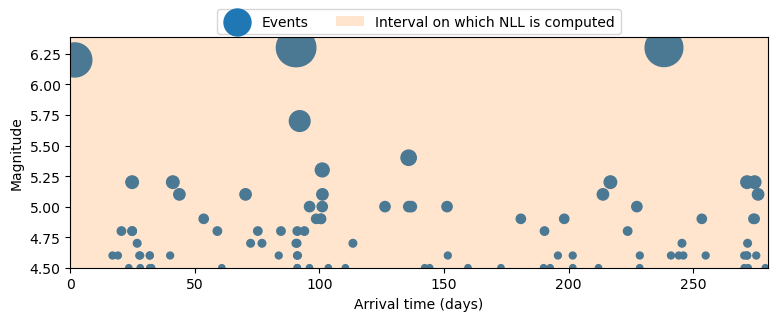

In [7]:
test_seq = catalog.test[2]
[eq.visualization.visualize_sequence(s, show_nll=True) for s in catalog.test[100:110]];

We would like to generate a 7-day forecast for the interval `[4000, 4007]`. For this, we select two subsequences:
- `past_seq`: Contains events from `[0, 4000]`, is used to condition the model
- `observed_seq`: Contains actually observed events from `[4000, 4007]`.

In [8]:
t_forecast = test_seq.arrival_times[test_seq.mag.argmax()]+9*1/24
duration = 20
num_samples = 50000
# Past events that we condition on
past_seq = test_seq.get_subsequence(0, t_forecast)
# Observed events in the 7-day forecast window
observed_seq = test_seq.get_subsequence(t_forecast, t_forecast + duration)

## Generate the forecast

In [9]:
# Use GPU to speed up forecasting, if possible
if torch.cuda.is_available():
    model.cuda()
    past_seq.cuda()

In [10]:
forecast = []
batch_size = 2000
total_samples = 0
for _ in tqdm(range(int(num_samples/batch_size))):
    forecast += model.sample(batch_size=batch_size, duration=duration, past_seq=past_seq, return_sequences=True)
    total_samples += batch_size

  0%|          | 0/25 [00:00<?, ?it/s]


RuntimeError: Expected hidden size (2, 2000, 32), got [1, 2000, 32]

`forecast` is a list, where each element is a `eq.data.Sequence` that represents a possible continuation of the catalog over the interval `[4000, 4007]`.

With the following function, we
- visualize 10 randomly chosen trajectories as a counting process
- plot the distribution of the total # of events in the forecast interval

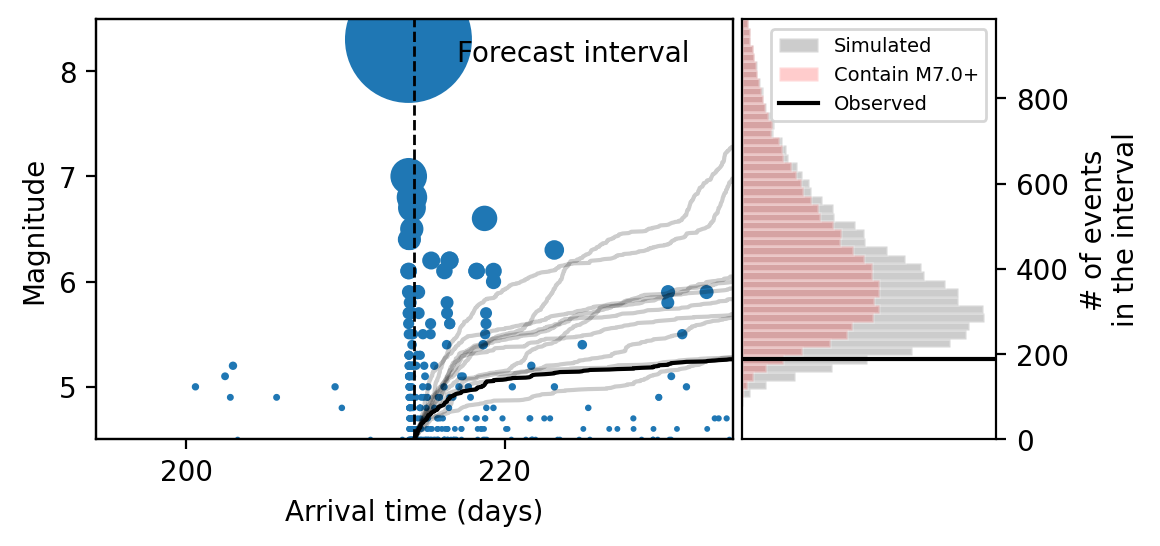

Dascher-Cousineau et al., 2019: 134.89634750336907


In [ ]:
eq.visualization.visualize_trajectories(test_seq, forecast,dpi=200,add_mag_threshold=7.0)
print("Dascher-Cousineau et al., 2019:", 10**(past_seq.mag.max().item()-6.17))
      

## M 7.8 - 26 km ENE of Nurdağı, Turkey
#### 2023-02-06 01:17:34 (UTC)37.225°N 37.021°E10.0 km depth


An interesting usecase is to apply it to sequences that have recently occured and compare the forecasts to those issued by the usgs

In [ ]:
# provide mainshock date an locations along with the window size to consider - preferably the same as the training catalog:
import pandas as pd 
import obspy
import sklearn
import numpy as np

earthquake_querry = {
    "latitude":37.64,
    "longitude":37.20,
    "start_time":pd.Timestamp("2019-01-01"),
    "end_time":pd.Timestamp.now(),
}

client = obspy.clients.fdsn.Client("Iris")
local_catalog = client.get_events(
    starttime=obspy.UTCDateTime(earthquake_querry["start_time"]),
    endtime=obspy.UTCDateTime(earthquake_querry["end_time"]),
    magnitudetype="MW",
    minmagnitude=catalog.metadata["mag_completeness"],
    latitude=earthquake_querry["latitude"],
    longitude=earthquake_querry["longitude"],
    maxradius=np.rad2deg(catalog.metadata['radius'] / 6378.1),
)

local_df = catalog.obspy2pd(local_catalog)
local_df = local_df.sort_values("time", ascending=[True])

t_start = 0.0
t_end = (earthquake_querry['end_time'] - earthquake_querry["start_time"])/ pd.Timedelta("1 day")

arrival_times = (
    (local_df.time - earthquake_querry["start_time"]) / pd.Timedelta("1 day")
).values

inter_times = np.diff(arrival_times, prepend=[t_start], append=[t_end])
mag = local_df.mag.values

querry_test_dataset = eq.data.InMemoryDataset(
    sequences=[
        eq.data.Sequence(
            inter_times=torch.as_tensor(inter_times, dtype=torch.float32),
            t_start=t_start,
            mag=torch.as_tensor(mag, dtype=torch.float32),
        )
    ]
)

<AxesSubplot:xlabel='Arrival time (days)', ylabel='Magnitude'>

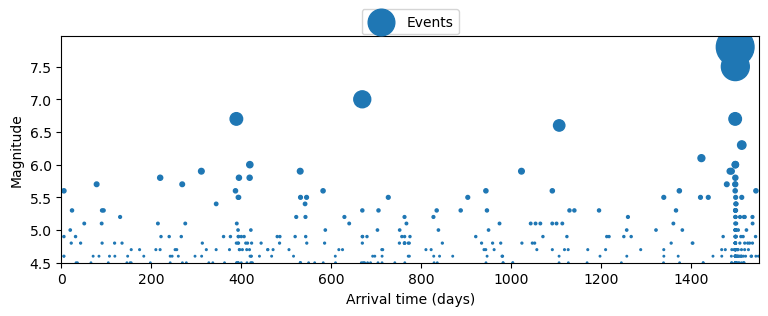

In [ ]:
eq.visualization.visualize_sequence(querry_test_dataset[0])

In [ ]:
model.richter_b = torch.Tensor([1.1])

In [ ]:
test_seq = querry_test_dataset[0]
t_forecast = test_seq.arrival_times[test_seq.mag.argmax()]+7
# t_forecast = test_seq.t_end
duration = 40
num_samples = 10000
# Past events that we condition on
past_seq = test_seq.get_subsequence(0, t_forecast)
# Observed events in the 7-day forecast window
observed_seq = test_seq.get_subsequence(t_forecast, min(test_seq.t_end,t_forecast + duration))

# Use GPU to speed up forecasting, if possible
if torch.cuda.is_available():
    model.cuda()
    past_seq.cuda()
    
forecast = []
batch_size = 2000
total_samples = 0
for _ in tqdm(range(int(num_samples/batch_size))):
    forecast += model.sample(batch_size=batch_size, duration=duration, past_seq=past_seq, return_sequences=True)
    total_samples += batch_size
      

100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


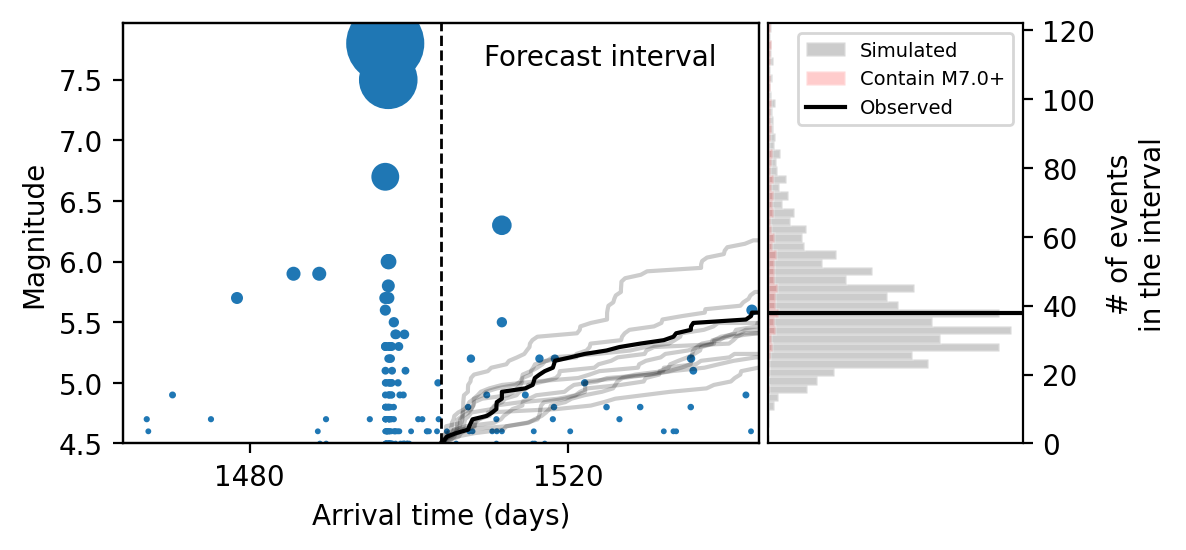

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
axA, axB = eq.visualization.visualize_trajectories(test_seq, forecast,dpi=200,add_mag_threshold=7.0)

x = np.arange(120)
# poisson distribution
lam = 40
y = np.random.poisson() 
axB.plot(x,y)
print("Dascher-Cousineau et al., 2019:", 10**(past_seq.mag.max().item()-6.17))

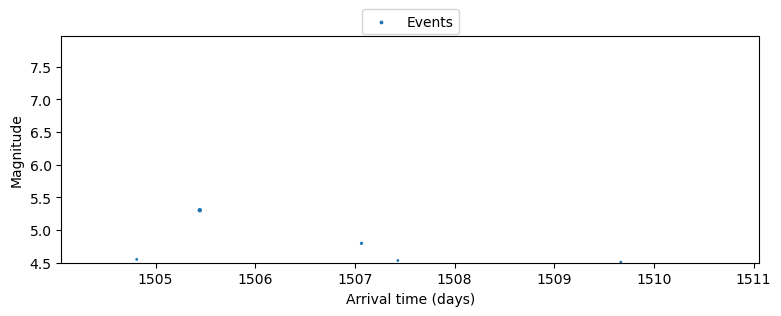

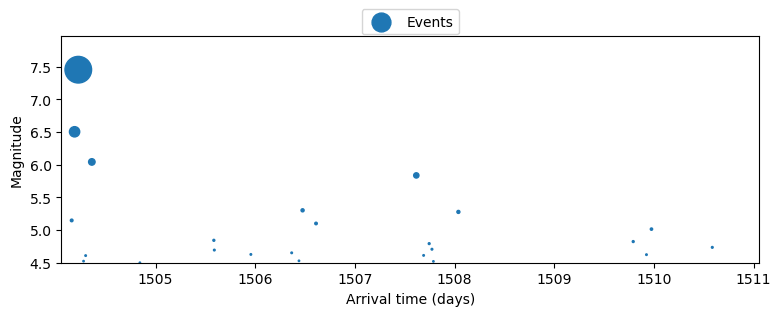

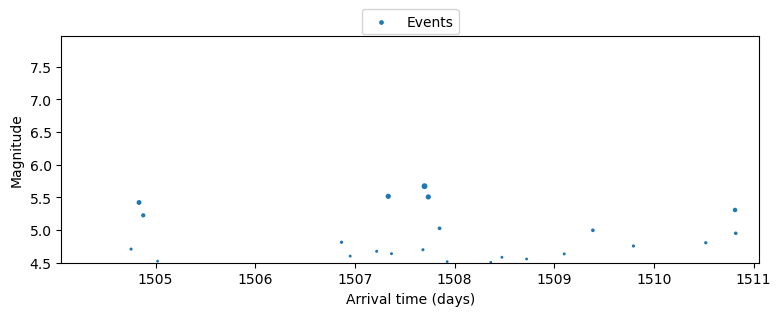

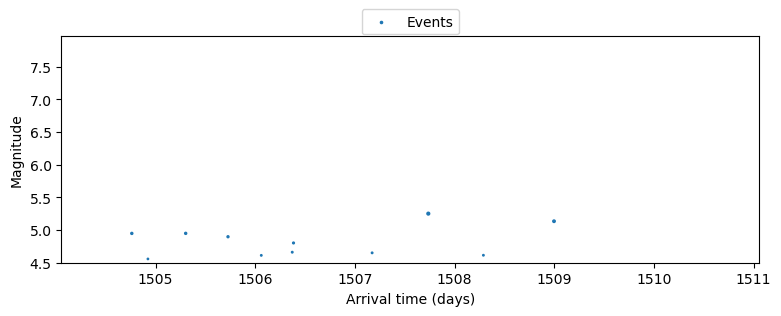

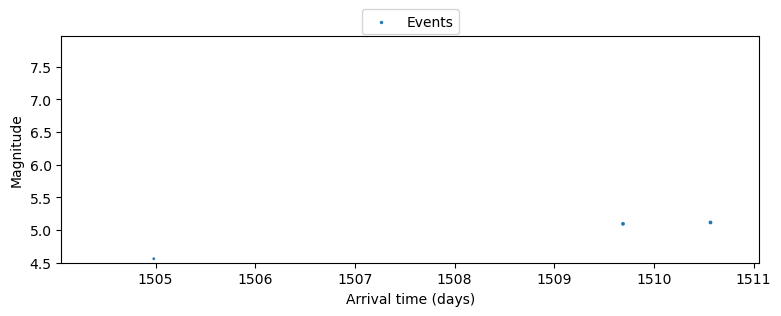

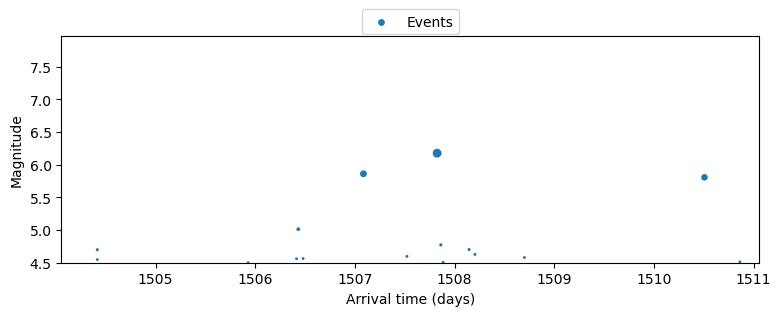

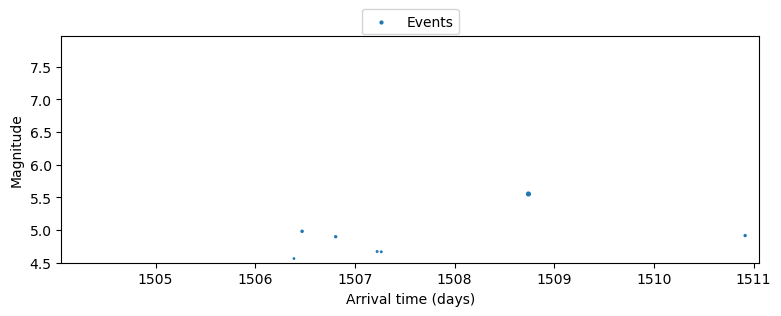

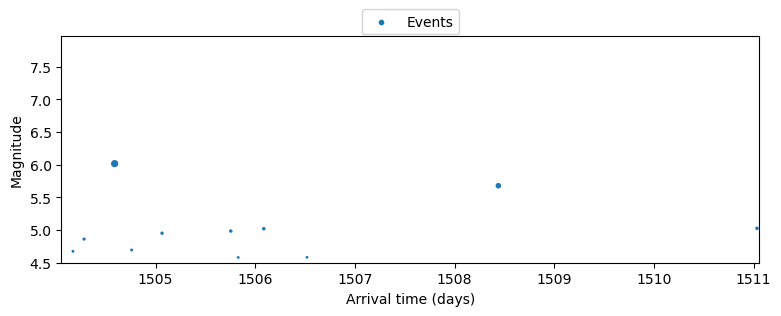

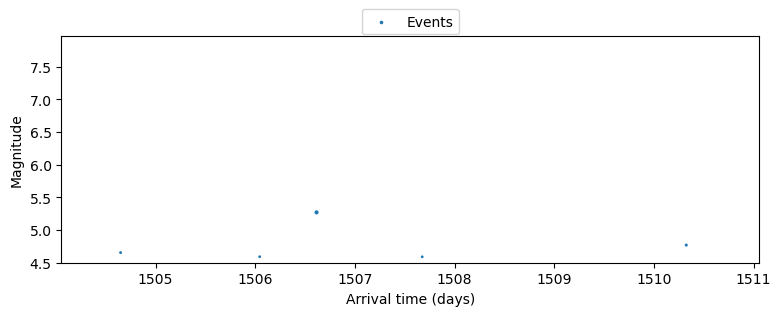

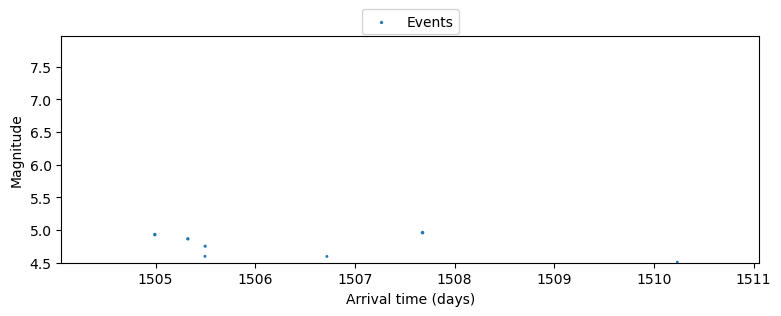

In [ ]:
for i in range(10):
    ax = eq.visualization.visualize_sequence(forecast[i])
    ax.set_ylim(axA.get_ylim()) 